In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import scipy

import zipfile
import os
import gc
import warnings

pd.options.mode.chained_assignment = None  # default='warn'

## <center>Instacart Model Notebook</center>

A simple decision tree model to predict product reorders with the instacart dataset.

#### Making Changes to the Pipeline

- If making changes to the pipeline, change the all_data variable to FALSE (two cells below). 
- As there is over 3 million rows it takes way too long to use the whole dataset when testing.

#### Using F1-Score

- F1 score is a great metric of model performance, balancing precision and recall. This is great in our case as we have >80% of products that are not reordered and therefore raw accuracy would be misleading.

#### Memory Limits

- Be very conscious of memory limits. I delete dataframes as I go to stay within Colab/Kaggle limits.
- Given the size of the dataset these limits are reached very easily

In [2]:
%%time
# Data variables
PATH = "../input/d/datasets/psparks/instacart-market-basket-analysis/"
missing_value_formats = ["n.a.","?","NA","n/a", "na", "--","-"]

for file in os.listdir(PATH):
    dfname = file.split('.')[0].replace("__","_")
    globals()[dfname] = pd.read_csv(PATH + file, na_values = missing_value_formats)
    print(dfname)

products
order_products_train
orders
order_products_prior
aisles
departments
CPU times: user 12.4 s, sys: 1.8 s, total: 14.2 s
Wall time: 19.7 s


In [3]:
# Set all_data to false if testing. 
# Using all the data takes a long time to train
all_data = False
if not all_data:
    ids = orders["user_id"].unique()[:1000]
    orders = orders[orders["user_id"].isin(ids)]

#creating a dataframe that will contain only prior information
op = pd.merge(orders, order_products_prior, on='order_id', how='inner')
op.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
0,2539329,1,prior,1,2,8,NaN,196,1,0
1,2539329,1,prior,1,2,8,NaN,14084,2,0
2,2539329,1,prior,1,2,8,NaN,12427,3,0
3,2539329,1,prior,1,2,8,NaN,26088,4,0
4,2539329,1,prior,1,2,8,NaN,26405,5,0


# Creating features related to the users. i.e using user_id

In [4]:
#Total number of orders placed by each users
users = op.groupby(by='user_id')['order_number'].aggregate('max').to_frame('u_num_of_orders').reset_index()
users.head()

,user_id,u_num_of_orders
0,1,10
1,2,14
2,3,12
3,4,5
4,5,4


In [5]:
#average number of products bought by the user in each purchase.

#1. First getting the total number of products in each order.
total_prd_per_order = op.groupby(by=['user_id', 'order_id'])['product_id'].aggregate('count').to_frame('total_products_per_order').reset_index()

#2. Getting the average products purchased by each user
avg_products = total_prd_per_order.groupby(by=['user_id'])['total_products_per_order'].mean().to_frame('u_avg_prd').reset_index()
avg_products.head()

#deleting the total_prd_per_order dataframe
del total_prd_per_order

In [6]:
#dow (Day of week) of most orders placed by each user 
dow = op.groupby(by='user_id')['order_dow'].agg(lambda x: scipy.stats.mode(x)[0]).to_frame('dow_most_orders_u').reset_index()
dow.head()

,user_id,dow_most_orders_u
0,1,4
1,2,2
2,3,0
3,4,4
4,5,3


In [7]:
#hour of day when most orders placed by each user
hod = op.groupby(by='user_id')['order_hour_of_day'].agg(lambda x: scipy.stats.mode(x)[0]).to_frame('hod_most_orders_u').reset_index()
hod.head()

,user_id,hod_most_orders_u
0,1,7
1,2,9
2,3,16
3,4,15
4,5,18


In [8]:
# Merging the user created features.

#1. merging avg_products with users
users = users.merge(avg_products, on='user_id', how='left')
#deleting avg_products
del avg_products

#2. merging dow with users.
users = users.merge(dow, on='user_id', how='left')
#deleting dow
del dow

#3. merging hod with users
users = users.merge(hod, on='user_id', how='left')
#deleting dow
del hod
users.head()

,user_id,u_num_of_orders,u_avg_prd,dow_most_orders_u,hod_most_orders_u
0,1,10,5.900000,4,7
1,2,14,13.928571,2,9
2,3,12,7.333333,0,16
3,4,5,3.600000,4,15
4,5,4,9.250000,3,18


# Creating features related to the products using product_id.

In [9]:
#number of time a product was purchased.
prd = op.groupby(by='product_id')['order_id'].agg('count').to_frame('prd_count_p').reset_index()
prd.head()

,product_id,prd_count_p
0,1,8
1,9,1
2,10,17
3,13,1
4,23,6


In [10]:
#products reorder ratio.
reorder_p = op.groupby(by='product_id')['reordered'].agg('mean').to_frame('p_reordered_ratio').reset_index()
reorder_p.head()

,product_id,p_reordered_ratio
0,1,0.250000
1,9,0.000000
2,10,0.647059
3,13,0.000000
4,23,0.166667


In [11]:
#merging the reorder_p with prd
prd = prd.merge(reorder_p, on='product_id', how='left')
#deleting reorder_p
del reorder_p
prd.head()

,product_id,prd_count_p,p_reordered_ratio
0,1,8,0.250000
1,9,1,0.000000
2,10,17,0.647059
3,13,1,0.000000
4,23,6,0.166667


# Creating user-product features.

In [12]:
#how many times a user bought the same product.
uxp = op.groupby(by=['user_id', 'product_id'])['order_id'].agg('count').to_frame('uxp_times_bought').reset_index()
uxp.head()

,user_id,product_id,uxp_times_bought
0,1,196,10
1,1,10258,9
2,1,10326,1
3,1,12427,10
4,1,13032,3


In [13]:
#reorder ratio of the user for each product.
reorder_uxp = op.groupby(by=['user_id', 'product_id'])['reordered'].agg('mean').to_frame('uxp_reordered_ratio').reset_index()
reorder_uxp.head()

,user_id,product_id,uxp_reordered_ratio
0,1,196,0.900000
1,1,10258,0.888889
2,1,10326,0.000000
3,1,12427,0.900000
4,1,13032,0.666667


In [14]:
#merging the two dataframes into one
uxp = uxp.merge(reorder_uxp, on=['user_id', 'product_id'], how='left')
#deleting reorder_uxp
del reorder_uxp
uxp.head()

,user_id,product_id,uxp_times_bought,uxp_reordered_ratio
0,1,196,10,0.900000
1,1,10258,9,0.888889
2,1,10326,1,0.000000
3,1,12427,10,0.900000
4,1,13032,3,0.666667


# Merging all the features into data DF.

In [15]:
#merging users df into uxp
data = uxp.merge(users, on='user_id', how='left')

#merging products df into data
data = data.merge(prd, on='product_id', how='left')
data.head()

#deleting unwanted dfs
del [users, prd, uxp]

# Creating Training + Validation

In [16]:
#keeping only the train eval set from the orders dataframe.
order_future = orders.loc[(orders["eval_set"] == 'train'), ['user_id', 'eval_set', 'order_id']]
order_future.head()

,user_id,eval_set,order_id
10,1,train,1187899
25,2,train,1492625
49,5,train,2196797
74,7,train,525192
78,8,train,880375


In [17]:
#merging the order_future with the data.
data = data.merge(order_future, on='user_id', how='left')
data.head()

,user_id,product_id,uxp_times_bought,uxp_reordered_ratio,u_num_of_orders,u_avg_prd,dow_most_orders_u,hod_most_orders_u,prd_count_p,p_reordered_ratio,eval_set,order_id
0,1,196,10,0.900000,10,5.9,4,7,149,0.724832,train,1187899.0
1,1,10258,9,0.888889,10,5.9,4,7,10,0.800000,train,1187899.0
2,1,10326,1,0.000000,10,5.9,4,7,20,0.350000,train,1187899.0
3,1,12427,10,0.900000,10,5.9,4,7,43,0.744186,train,1187899.0
4,1,13032,3,0.666667,10,5.9,4,7,6,0.333333,train,1187899.0


In [18]:
#preparing the train df.
data_train = data[data.eval_set == 'train']
data_train.head()

,user_id,product_id,uxp_times_bought,uxp_reordered_ratio,u_num_of_orders,u_avg_prd,dow_most_orders_u,hod_most_orders_u,prd_count_p,p_reordered_ratio,eval_set,order_id
0,1,196,10,0.900000,10,5.9,4,7,149,0.724832,train,1187899.0
1,1,10258,9,0.888889,10,5.9,4,7,10,0.800000,train,1187899.0
2,1,10326,1,0.000000,10,5.9,4,7,20,0.350000,train,1187899.0
3,1,12427,10,0.900000,10,5.9,4,7,43,0.744186,train,1187899.0
4,1,13032,3,0.666667,10,5.9,4,7,6,0.333333,train,1187899.0


In [19]:
#merging the information from the order_proucts_train df into the data_train.
data_train = data_train.merge(order_products_train[['product_id', 'order_id', 'reordered']], on=['product_id', 'order_id'], how='left')
data_train.head()

,user_id,product_id,uxp_times_bought,uxp_reordered_ratio,u_num_of_orders,u_avg_prd,dow_most_orders_u,hod_most_orders_u,prd_count_p,p_reordered_ratio,eval_set,order_id,reordered
0,1,196,10,0.900000,10,5.9,4,7,149,0.724832,train,1187899.0,1.0
1,1,10258,9,0.888889,10,5.9,4,7,10,0.800000,train,1187899.0,1.0
2,1,10326,1,0.000000,10,5.9,4,7,20,0.350000,train,1187899.0,NaN
3,1,12427,10,0.900000,10,5.9,4,7,43,0.744186,train,1187899.0,NaN
4,1,13032,3,0.666667,10,5.9,4,7,6,0.333333,train,1187899.0,1.0


In [20]:
#filling the NAN values
data_train['reordered'].fillna(0, inplace=True)

#setting user_id and product_id as index.
data_train = data_train.set_index(['user_id', 'product_id'])

#deleting eval_set, order_id as they are not needed for training.
data_train.drop(['eval_set', 'order_id'], axis=1, inplace=True)
data_train.head()

uxp_times_bought  uxp_reordered_ratio  u_num_of_orders  \
user_id product_id                                                           
1       196                       10             0.900000               10   
        10258                      9             0.888889               10   
        10326                      1             0.000000               10   
        12427                     10             0.900000               10   
        13032                      3             0.666667               10   

                    u_avg_prd  dow_most_orders_u  hod_most_orders_u  \
user_id product_id                                                    
1       196               5.9                  4                  7   
        10258             5.9                  4                  7   
        10326             5.9                  4                  7   
        12427             5.9                  4                  7   
        13032             5.9                  4                  7   

                    prd_count_p  p_reordered_ratio  reordered  
user_id product_id                                             
1       196                 149           0.724832        1.0  
        10258                10           0.800000        1.0  
        10326                20           0.350000        0.0  
        12427                43           0.744186        0.0  
        13032                 6           0.333333        1.0

In [21]:
#deleting unwanted df
del [aisles, departments, order_products_prior, order_products_train, orders, order_future, data] #order_future, data

In [22]:
#resetting index
data_train.reset_index(inplace=True)

data_train.head()

,user_id,product_id,uxp_times_bought,uxp_reordered_ratio,u_num_of_orders,u_avg_prd,dow_most_orders_u,hod_most_orders_u,prd_count_p,p_reordered_ratio,reordered
0,1,196,10,0.900000,10,5.9,4,7,149,0.724832,1.0
1,1,10258,9,0.888889,10,5.9,4,7,10,0.800000,1.0
2,1,10326,1,0.000000,10,5.9,4,7,20,0.350000,0.0
3,1,12427,10,0.900000,10,5.9,4,7,43,0.744186,0.0
4,1,13032,3,0.666667,10,5.9,4,7,6,0.333333,1.0


In [23]:
#merging the aisles and department ids to with the train and test data
data_train = data_train.merge(products[['product_id', 'aisle_id']], on='product_id', how='left')

#department
data_train = data_train.merge(products[['product_id', 'department_id']], on='product_id', how='left')

#setting user_id and product_id as index.
data_train = data_train.set_index(['user_id', 'product_id'])

In [24]:
#creating training and validation set
train, valid = sklearn.model_selection.train_test_split(data_train, test_size=0.1)
del data_train

# Building XGB Model

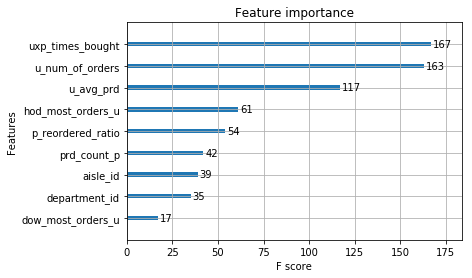

In [25]:
#creating data and labels
X_train, y_train = train.drop('reordered', axis=1), train['reordered']

#setting boosters parameters
parameters = {
    'eval_metric' : 'logloss',
    'max_depth' : 5,
    'colsample_bytree' : 0.4,
    'subsample' : 0.8
}

#instantiating the model
xgb_clf = xgb.XGBClassifier(objective='binary:logistic', parameters=parameters, num_boost_round=10) #change to 10

#training model
model = xgb_clf.fit(X_train, y_train)
model.save_model("model.txt")

#feature importance plot
xgb.plot_importance(model)

# Making Validation Predictions

In [26]:
#creating data and labels
X_valid, y_valid = valid.drop('reordered', axis=1), train['reordered']

#predicting on the testing data
# y_pred = xgb_clf.predict(X_valid).astype('int')

#setting a threshold.?
y_pred = (xgb_clf.predict_proba(X_valid)[:, 1] >= 0.21).astype('int')

#saving the prediction as a new column in data_test
valid['prediction'] = y_pred
valid.head()

,,uxp_times_bought,uxp_reordered_ratio,u_num_of_orders,u_avg_prd,dow_most_orders_u,hod_most_orders_u,prd_count_p,p_reordered_ratio,reordered,aisle_id,department_id,prediction
user_id,product_id,,,,,,,,,,,,
235,9366,1,0.000000,21,9.142857,0,11,47,0.553191,0.0,131,9,0
566,9387,3,0.666667,13,10.846154,5,9,152,0.657895,0.0,24,4,0
280,47209,2,0.500000,41,12.926829,0,20,1068,0.805243,0.0,24,4,0
448,45104,1,0.000000,33,13.545455,0,9,49,0.510204,0.0,91,16,0
655,47823,1,0.000000,78,8.730769,0,19,2,0.000000,0.0,120,16,0


In [27]:
#valid f1_score
    print('F1 score: ', sklearn.metrics.f1_score(valid['reordered'], valid['prediction']))

F1 score:  0.3946488294314381


In [28]:
# Writing DF to disk for later eval
with warnings.catch_warnings():
    warnings.simplefilter('ignore')

    #writing validation file to disk
    valid.reset_index().to_csv("validation.csv")